In [62]:
import cv2
import numpy as np
import torch
from torch.autograd import Variable
from torchvision import models
import matplotlib.pyplot as plt
import os
import torch.nn as nn

In [63]:
def preprocess_image(cv2im, resize_im=True):

    # Resize image
    if resize_im:
        cv2im = cv2.resize(cv2im, (224, 224))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

In [64]:
class FeatureVisualization():
    def __init__(self,img_path,selected_layer):
        self.img_path=img_path
        self.selected_layer=selected_layer
        # Load pretrained model
        
        self.pretrained_model = models.vgg16(pretrained=True).features
        self.pretrained_model.eval()
        self.pretrained_model2 = models.vgg16(pretrained=True)
        #self.pretrained_model2 = models.resnet50(pretrained=True)
        self.pretrained_model2.eval()
    def process_image(self):
        img=cv2.imread(self.img_path)
        img=preprocess_image(img)
        return img

    def get_feature(self):
        # Image  preprocessing
        input=self.process_image()
        #print("input.shape:{}".format(input.shape))
        x=input
        for index,layer in enumerate(self.pretrained_model):
            x=layer(x)
            if (index == self.selected_layer):
                return x

    def get_single_feature(self):
        # Get the feature map

        features=self.get_feature()
        #print(features.shape)
        feature=features[:,0,:,:]
        feature=feature.view(feature.shape[1],feature.shape[2])

        #print("feature")
        #print(feature.shape)
        return feature

    def get_multi_feature(self):
        # Get the feature map
        features=self.get_feature()
        #print(features.shape)
        result_path = './feat_first' + str(self.selected_layer)

        if not os.path.exists(result_path):
            os.makedirs(result_path)
        print("On layer:{}, We can get the {} feature maps".format(self.selected_layer,features.shape[1]))    
        #print(features.shape[1])
        for i in range(features.shape[1]):
            feature=features[:,i,:,:]
            feature=feature.view(feature.shape[1],feature.shape[2])
            feature = feature.data.numpy()
            feature = 1.0 / (1 + np.exp(-1 * feature))
            feature = np.round(feature * 255)
            save_name = result_path + '/' + str(i) + '.jpg'
            cv2.imwrite(save_name, feature)
    def get_multi_feature1(self):
        # Get the feature map
        features=self.get_feature()
        #print(features.shape)
        result_path = './feat_second' + str(self.selected_layer)

        if not os.path.exists(result_path):
            os.makedirs(result_path)
        print("On layer:{}, We can get the {} feature maps".format(self.selected_layer,features.shape[1]))    
        #print(features.shape[1])
        for i in range(features.shape[1]):
            feature=features[:,i,:,:]
            feature=feature.view(feature.shape[1],feature.shape[2])
            feature = feature.data.numpy()
            feature = 1.0 / (1 + np.exp(-1 * feature))
            feature = np.round(feature * 255)
            save_name = result_path + '/' + str(i) + '.jpg'
            cv2.imwrite(save_name, feature)

    def save_feature_to_img(self):
        #to numpy
        feature=self.get_single_feature()
        self.get_multi_feature()
        feature=feature.data.numpy()

        #use sigmod to [0,1]
        # print(feature[0])
        feature= 1.0/(1+np.exp(-1*feature))

        # to [0,255]
        feature=np.round(feature*255)
        #print(self.selected_layer)
        save_name = './feat_first' + str(self.selected_layer) + '.jpg'
        cv2.imwrite(save_name, feature)
    def save_feature_to_img1(self):
        #to numpy
        feature=self.get_single_feature()
        self.get_multi_feature1()
        feature=feature.data.numpy()

        #use sigmod to [0,1]
        # print(feature[0])
        feature= 1.0/(1+np.exp(-1*feature))

        # to [0,255]
        feature=np.round(feature*255)
        #print(self.selected_layer)
        save_name = './feat_second' + str(self.selected_layer) + '.jpg'
        cv2.imwrite(save_name, feature)
    def plot_probablity(self,outputs):

        outputs = outputs.data.numpy()
        outputs = np.ndarray.tolist(outputs)

        x = range(0, 1000)
        plt.bar(x, outputs[0])
        plt.xlabel("Class")
        plt.ylabel("Probablity")
        plt.title("Image classifier")
        plt.show()


    def predict(self):
        input=self.process_image()
        outputs = self.pretrained_model2(input)

        s = torch.nn.Softmax(dim=1)
        result = s(outputs)
        self.plot_probablity(result)

        prob, predicted = result.sort(1,descending=True)
        prob = prob.data.numpy()

        predicted = predicted.data.numpy()
        
        print("Probablity TOP-3:\n")
        print("")
        for i in range(3):
            
            print("TOP_"+str(i+1))
            print("Probablity:{}".format(prob[0][i]))
            print("Predicted:{}\n".format(c[int(predicted[0][i])]))
        return outputs

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

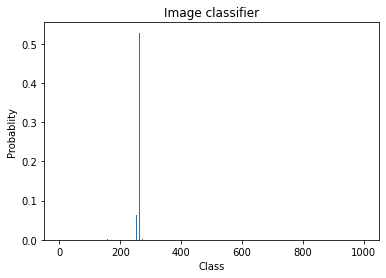

Probablity TOP-3:


TOP_1
Probablity:0.5287235379219055
Predicted: 'Pembroke

TOP_2
Probablity:0.40296420454978943
Predicted: 'Cardigan

TOP_3
Probablity:0.06319654732942581
Predicted: 'basenji'

The second picture classification predict:


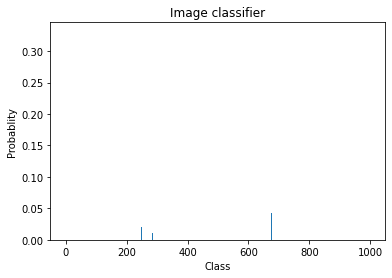

Probablity TOP-3:


TOP_1
Probablity:0.3292691111564636
Predicted: 'Eskimo dog

TOP_2
Probablity:0.15182453393936157
Predicted: 'chow

TOP_3
Probablity:0.14208169281482697
Predicted: 'Siberian husky'

Verification:
They are the same!
Their cosine_distance:tensor([0.2710], grad_fn=<RsubBackward1>)
Their euclidean_dist:75.74112701416016


In [65]:
if __name__=='__main__':
    # get class
    c = {}
    with open("imagenet1000_clsidx_to_labels.txt") as f:
        for line in f:
            (key, val) = line.split(":")
            c[int(key)] = val.split(",")[0]
    # Define image path and select the layer
    myClass=FeatureVisualization('./dog6.jpg',5)
    Compare=FeatureVisualization('./dog9.jpg',5)    
    print(myClass.pretrained_model2)

    myClass.save_feature_to_img()
    Compare.save_feature_to_img1()
    print("The first picture classification predict:")
    myClass_vector = myClass.predict()
    print("The second picture classification predict:")
    Compare_vector = Compare.predict()
    #Define cosine similarity
    cos= nn.CosineSimilarity(dim=1)
    #Define Euclidean distance
    euclidean_dist = torch.dist(myClass_vector,Compare_vector,p=2)
    cosine_dist = 1-cos(myClass_vector,Compare_vector)
    print("Verification:")
    if cosine_dist < 0.6:
        print("They are the same!")
        print("Their cosine_distance:{}".format(cosine_dist))
    else:
        print("They are not the same!")
        print("Their cosine_distance:{}".format(cosine_dist))
       
    print("Their euclidean_dist:{}".format(euclidean_dist))